### Set Up Environment:

In [43]:
import pandas as pd
import numpy as np
import json
import time
from matplotlib_venn import venn2, venn3
from sklearn.metrics.pairwise import cosine_similarity
plt.style.use('seaborn-bright')
import seaborn as sns

### Install Node.js and Create Web Application:

### Install spotipy library and import:

In [9]:
pip install spotipy

Note: you may need to restart the kernel to use updated packages.


In [10]:
f = open('my_secrets.txt', "r")
my_user_id = f.readline()
my_user_id = '1227205646'

%env SPOTIPY_CLIENT_ID = f5aca3c4a8db4243ba150971bdde2a4e
%env SPOTIPY_CLIENT_SECRET= f905f54733484b30a129f4b4be685cc6

env: SPOTIPY_CLIENT_ID=f5aca3c4a8db4243ba150971bdde2a4e
env: SPOTIPY_CLIENT_SECRET=f905f54733484b30a129f4b4be685cc6


In [11]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

### Test Query:

In [12]:
results = sp.search(q='weezer', limit=20)
for idx, track in enumerate(results['tracks']['items']):
    print(idx, track['name'])

0 Island In The Sun
1 Say It Ain't So
2 Buddy Holly
3 Lost in the Woods - Weezer Version
4 Beverly Hills
5 Undone - The Sweater Song
6 Africa
7 Hash Pipe
8 My Name Is Jonas
9 Feels Like Summer
10 Pork And Beans
11 The End of the Game
12 Take On Me
13 El Scorcho
14 Perfect Situation
15 Everybody Wants To Rule The World
16 Only In Dreams
17 The Good Life
18 Mr. Blue Sky
19 The World Has Turned And Left Me Here


### Functions for Web API Gets:

In [14]:
def get_analysis(track_id='4o05DiC0RQ9DNtGJGauwna'):
    '''
    Makes a request to the spotify API that returns an analysis of the track
    
    Parameters:
    track_id: string 
    
    Returns:
    json object
    
    '''
    import json
    import time
    #import sys
    start = time.time()
    analysis = sp.audio_analysis(track_id)
    delta = time.time() - start
    print(json.dumps(analysis, indent=4))
    print("analysis retrieved in %.2f seconds" % (delta,))

In [15]:
def get_features(track_id='4o05DiC0RQ9DNtGJGauwna'):
    '''
    Makes a request to the Spotify API that returns the features of the track.
    
    Parameters:
    track_id: string
    
    Returns:
    json objet
    '''
    import json
    
    features = sp.audio_features(track_id)
    print(json.dumps(features, indent=4))
    return features

In [16]:
def get_playlists(user_id = '1227205646' ): #this is my personal user id
    '''
    Makes a request to the spotify API that returns the playlist objects in a users library
    
    Parameters: 
    user_id: string
    
    Returns: json playlist object
    '''
    playlists = sp.user_playlists(user_id)
    return playlists

In [17]:
def get_tracks(playlist_id):
    '''Takes a playlist id and returns a json object of its tracks'''
    return sp.playlist_tracks(playlist_id)

In [18]:
def get_list_of_playlists(playlists):
    list_of_playlists = []
    for dic in playlists['items']:
        identification = dic['id']
        list_of_playlists.append(identification)
    return list_of_playlists

In [19]:
### Manually get id's for three playlists I'm interested in to start:
global_top50 = "37i9dQZEVXbMDoHDwVN2tF?si=W6KUPczdSc2KL1TKSH-BXA"
usa_top50 = "37i9dQZEVXbLRQDuF5jeBp"
uk_top50 = "1QM1qz09ZzsAPiXphF1l4S"
#mexico
#canada
# top 50 as of 0900AM EST 07APR2020

In [20]:
### Function for selecting only the track id's from a playlist (previous function returned the entire 'tracks' json object)
def getTrackIDs(user, playlist_id): 
    ids = []
    playlist = sp.user_playlist(user, playlist_id)
    for item in playlist['tracks']['items']:
        track = item['track']
        ids.append(track['id'])
    return ids

In [21]:
#get track ids for the three playlists I chose
global_ids = getTrackIDs(my_user_id, global_top50) # for this function to work, playlist must be in my personal library even if it is a public playlist
usa_ids = getTrackIDs(my_user_id, usa_top50)
uk_ids = getTrackIDs(my_user_id, uk_top50)


In [22]:
def get_Genres(artist_id):
    artist = sp.artist(artist_id)
    genres = artist["genres"]
    return genres
get_Genres('1Xyo4u8uXC1ZmMpatF05PJ') #test

['canadian contemporary r&b', 'canadian pop', 'pop']

###### Function modifed from code in Medium Article - https://medium.com/better-programming/how-to-extract-any-artists-data-using-spotify-s-api-python-and-spotipy-4c079401bc37

In [51]:
### Collect only the fields we want for each track
def getTrackFeatures(id):
    meta = sp.track(id)
    features = sp.audio_features(id)
    if features[0] is None: #if features is NoneType, don't collect data for that track
        return

    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    artist_id = meta['album']['artists'][0]['id']
    genres = get_Genres(artist_id)
    #release_date = meta['album']['release_date']
    #length = meta['duration_ms']
    #popularity = meta['popularity']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    #time_signature = features[0]['time_signature']
    
    track = [id, name, album, artist, artist_id, genres, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo]
    #track = [name, album, artist, release_date, length, popularity, danceability, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo, time_signature]
    return track

###### Function modifed from code in Medium Article - https://medium.com/better-programming/how-to-extract-any-artists-data-using-spotify-s-api-python-and-spotipy-4c079401bc37

In [52]:
def features_for_ids(ids):
    # loop over track ids 
    tracks = []
    #for i in range(3):
    for i in range(len(ids)):
        time.sleep(.5)
        track = getTrackFeatures(ids[i])
        if track is None: #if track features is NoneType, don't add the track to database
            pass
        else:
            tracks.append(track)

        # create dataset
    df = pd.DataFrame(tracks, columns = ['track_id', 'name', 'album', 'artist', 'artist_id', 'genres', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo'])
        #df.to_csv("spotify.csv", sep = ',')
    return df


### Create DataFrames for Each Playlist

In [53]:
global_df = features_for_ids(global_ids)
usa_df = features_for_ids(usa_ids)
uk_df = features_for_ids(uk_ids)
## add atleast two more countries

In [54]:
global_df.head()
usa_df.head()
uk_df.head()

,track_id,name,album,artist,artist_id,genres,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
0,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,After Hours,The Weeknd,1Xyo4u8uXC1ZmMpatF05PJ,"[canadian contemporary r&b, canadian pop, pop]",0.00146,0.514,0.730,0.000095,0.0897,-5.934,0.0598,171.005
1,127QTOFJsJQp5LbJbu3A1y,Toosie Slide,Toosie Slide,Drake,3TVXtAsR1Inumwj472S9r4,"[canadian hip hop, canadian pop, hip hop, pop ...",0.32100,0.834,0.454,0.000006,0.1140,-9.750,0.2010,81.618
2,24Yi9hE78yPEbZ4kxyoXAI,Roses - Imanbek Remix,Roses (Imanbek Remix),SAINt JHN,0H39MdGGX6dbnnQPt6NQkZ,"[melodic rap, pop rap, rap, trap]",0.01670,0.770,0.724,0.010500,0.3530,-5.484,0.0495,121.974
3,3PfIrDoz19wz7qK7tYeu62,Don't Start Now,Future Nostalgia,Dua Lipa,6M2wZ9GZgrQXHCFfjv46we,"[dance pop, pop, uk pop]",0.01250,0.794,0.793,0.000000,0.0952,-4.521,0.0842,123.941
4,0nbXyq5TXYPCO7pr3N8S4I,The Box,Please Excuse Me For Being Antisocial,Roddy Ricch,757aE44tKEUQEqRuT6GnEB,[melodic rap],0.10400,0.896,0.586,0.000000,0.7900,-6.687,0.0559,116.971


,track_id,name,album,artist,artist_id,genres,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
0,127QTOFJsJQp5LbJbu3A1y,Toosie Slide,Toosie Slide,Drake,3TVXtAsR1Inumwj472S9r4,"[canadian hip hop, canadian pop, hip hop, pop ...",0.32100,0.834,0.454,0.000006,0.1140,-9.750,0.2010,81.618
1,0nbXyq5TXYPCO7pr3N8S4I,The Box,Please Excuse Me For Being Antisocial,Roddy Ricch,757aE44tKEUQEqRuT6GnEB,[melodic rap],0.10400,0.896,0.586,0.000000,0.7900,-6.687,0.0559,116.971
2,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,After Hours,The Weeknd,1Xyo4u8uXC1ZmMpatF05PJ,"[canadian contemporary r&b, canadian pop, pop]",0.00146,0.514,0.730,0.000095,0.0897,-5.934,0.0598,171.005
3,22LAwLoDA5b4AaGSkg6bKW,Blueberry Faygo,Certified Hitmaker,Lil Mosey,5zctI4wO9XSKS8XwcnqEHk,"[melodic rap, rap, rap conscient, trap, vapor ...",0.20700,0.774,0.554,0.000000,0.1320,-7.909,0.0383,99.034
4,24Yi9hE78yPEbZ4kxyoXAI,Roses - Imanbek Remix,Roses (Imanbek Remix),SAINt JHN,0H39MdGGX6dbnnQPt6NQkZ,"[melodic rap, pop rap, rap, trap]",0.01670,0.770,0.724,0.010500,0.3530,-5.484,0.0495,121.974


,track_id,name,album,artist,artist_id,genres,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
0,5px6upUHM3fhOP621Edp4V,Physical,Physical,Dua Lipa,6M2wZ9GZgrQXHCFfjv46we,"[dance pop, pop, uk pop]",0.0137,0.647,0.844,0.000658,0.102,-3.756,0.0457,146.962
1,2ZEq4HT450Ye9IFGPTl9qV,Lonely,Lonely,Joel Corry,6DgP9otnZw5z6daOntINxp,"[deep groove house, house, uk dance]",0.0946,0.697,0.921,0.000019,0.159,-4.283,0.0424,123.988
2,5hff5RQeE84pznOt8WEWeO,Birthday,Birthday,Anne-Marie,1zNqDE7qDGCsyzJwohVaoX,"[dance pop, pop, post-teen pop, tropical house...",0.0502,0.609,0.785,0.000000,0.171,-3.320,0.0891,151.995
3,24Yi9hE78yPEbZ4kxyoXAI,Roses - Imanbek Remix,Roses (Imanbek Remix),SAINt JHN,0H39MdGGX6dbnnQPt6NQkZ,"[melodic rap, pop rap, rap, trap]",0.0167,0.770,0.724,0.010500,0.353,-5.484,0.0495,121.974
4,2XU0oxnq2qxCpomAAuJY8K,Dance Monkey,Dance Monkey (Stripped Back) / Dance Monkey,Tones And I,2NjfBq1NflQcKSeiDooVjY,[australian pop],0.6920,0.824,0.588,0.000104,0.149,-6.400,0.0924,98.027


In [55]:
global_df.describe()
usa_df.describe()
uk_df.describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
count,50.000000,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000,50.000000
mean,0.228884,0.743000,0.621500,1.648593e-02,0.175262,-6.068680,0.134052,122.428160
std,0.247243,0.123907,0.152128,9.424920e-02,0.158205,2.211528,0.109738,26.899262
min,0.001460,0.430000,0.225000,0.000000e+00,0.057400,-14.454000,0.029000,75.801000
25%,0.042450,0.676000,0.538500,0.000000e+00,0.088950,-6.734250,0.056250,100.287000
50%,0.156000,0.767000,0.613000,6.950000e-07,0.106500,-5.612500,0.092200,117.459500
75%,0.298750,0.835500,0.729750,8.080000e-05,0.194000,-4.581000,0.179000,140.309750
max,0.902000,0.923000,0.955000,6.570000e-01,0.790000,-2.957000,0.481000,193.896000


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.205354,0.746060,0.624320,0.013529,0.201174,-6.043960,0.146588,124.891900
std,0.234002,0.127988,0.136392,0.092874,0.157610,2.019029,0.110702,26.001864
min,0.001460,0.430000,0.225000,0.000000,0.059600,-14.454000,0.030500,75.801000
25%,0.036600,0.680750,0.548000,0.000000,0.102000,-6.734250,0.057500,104.489750
50%,0.125000,0.774500,0.617500,0.000000,0.139500,-5.612500,0.105700,122.957500
75%,0.268750,0.836000,0.729750,0.000001,0.258000,-4.806750,0.216750,142.741250
max,0.902000,0.923000,0.955000,0.657000,0.790000,-3.158000,0.481000,180.051000


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000
mean,0.207442,0.678520,0.683640,0.003682,0.193468,-5.36942,0.085470,113.542500
std,0.239954,0.115643,0.169296,0.017555,0.156778,1.73039,0.069539,22.504201
min,0.001470,0.420000,0.267000,0.000000,0.044000,-11.14400,0.028700,73.877000
25%,0.041725,0.602750,0.599750,0.000000,0.094150,-6.38125,0.042575,96.139750
50%,0.122500,0.672000,0.690500,0.000000,0.149000,-5.12150,0.055000,114.991500
75%,0.253750,0.746250,0.797500,0.000011,0.212500,-4.10750,0.106350,125.742250
max,0.913000,0.922000,0.955000,0.110000,0.790000,-2.72900,0.352000,171.017000


In [56]:
global_set = set(global_df.name)
usa_set = set(usa_df.name)
uk_set = set(uk_df.name)
set_list = [global_set, usa_set, uk_set]

### Questions:

#### What is the intersection set of Global Top 50 and USA Top 50?

<Figure size 576x396 with 0 Axes>

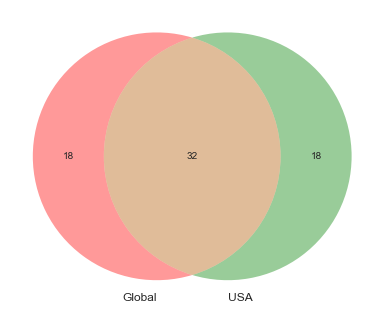

In [57]:
plt.figure(facecolor='white')
fig1 = venn2([global_set, usa_set],('Global', 'USA'))
plt.savefig('global_U_usa', dpi=240)


#### How does this compare to the Intersection Sets w/ other countries?

<Figure size 576x396 with 0 Axes>

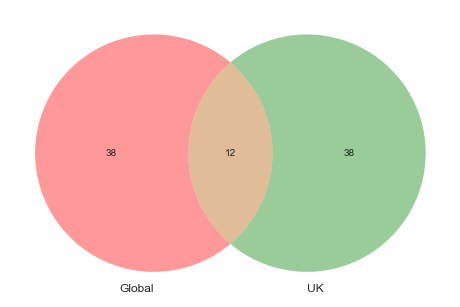

In [58]:
plt.figure(facecolor='white')
fig2 = venn2([global_set, uk_set], ('Global', 'UK'))
plt.savefig('global_U_uk', dpi=240)

<Figure size 576x396 with 0 Axes>

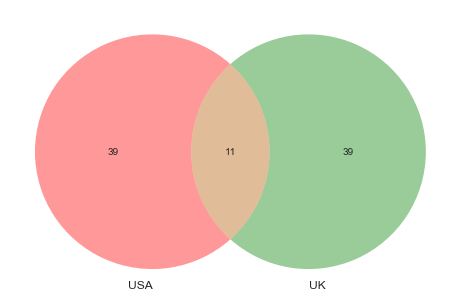

In [59]:
plt.figure(facecolor='white')
fig3 = venn2([usa_set, uk_set], ('USA', 'UK'))
plt.savefig('usa_U_uk', dpi=240)

<Figure size 576x396 with 0 Axes>

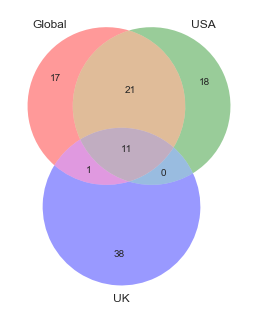

In [60]:
plt.figure(facecolor='white')
venn3(set_list, ('Global', 'USA', 'UK'))
plt.savefig('global_U_usa_U_uk', dpi=240)

#### Do the averages of the features of the Global Top 50 differ significantly from those of USA Top 50?

In [61]:
# find cosine similiarity between the average vectors
def feature_similarity(df1, df2):
    vector1 = np.array(df1.mean())
    vector2 = np.array(df2.mean())
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    #normalize the length and tempo and time_signature
    vector1 = vector1/norm1
    vector2 = vector2/norm2
    #calculate the similarity
    return vector1.dot(vector2)/(norm1 * norm2)

feature_similarity(global_df, usa_df) #test  

6.52399492828199e-05

#### What is the correlation between features?

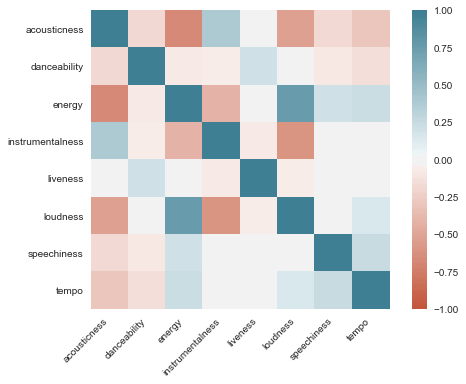

In [71]:
#come back to this and create a merged dataframe of all the regions, then recalculate.
def feature_correlation_map(dataframe):
    title = str(dataframe.name)
    corr = dataframe.corr()
    ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
    )
    ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
    )   
    

feature_correlation_map(global_df) #test
plt.savefig('global_correlation', dpi=240)

#### Which country's musical taste is most similar to USA? (using similarity of features)

#### Which country's musical taste is most similar to USA? (using similarity of genre strings)

In [81]:
#write a function that takes the genres from every song in a playlist and combines them into one string
def string_all_genres(df):
    document = ''
    for genre_list in df.genres:
        for string in genre_list:
            document += ' ' + string
    return document

In [83]:
global_genres = string_all_genres(global_df)
usa_genres = string_all_genres(usa_df)
uk_genres = string_all_genres(uk_df)
#mexico
#canada

### Feature Descriptions

<img src="features_table.png">